<a href="https://colab.research.google.com/github/HashirNauman/Sentiment_Analysis_with_BERT/blob/main/Sentiment_Analysis_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.QKDU79_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.QKDU79_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.QKDU79_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
2500/2500 [==============================] - 692s 268ms/step - loss: 0.3548 - accuracy: 0.8415 - val_loss: 0.2996 - val_accuracy: 0.8732
Epoch 2/3
2500/2500 [==============================] - 664s 265ms/step - loss: 0.2155 - accuracy: 0.9140 - val_loss: 0.3070 - val_accuracy: 0.8798
Epoch 3/3
3125/3125 [==============================] - 258s 83ms/step - loss: 0.3946 - accuracy: 0.8796
Test Loss: 0.3946, Test Accuracy: 0.8796
1/1 [==============================] - 0s 93ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.84      0.88     12500
    positive       0.85      0.91      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Model and tokenizer saved to 'sentiment_bert_model'.


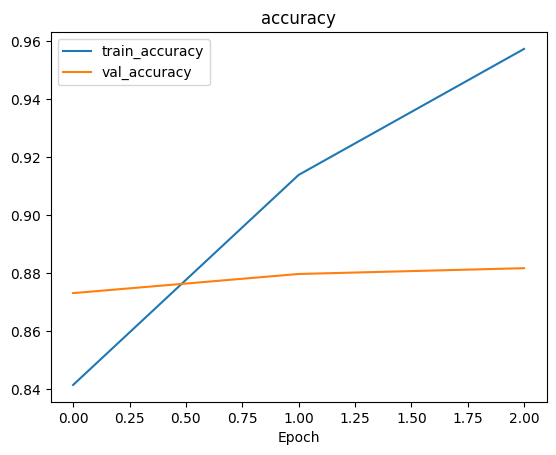

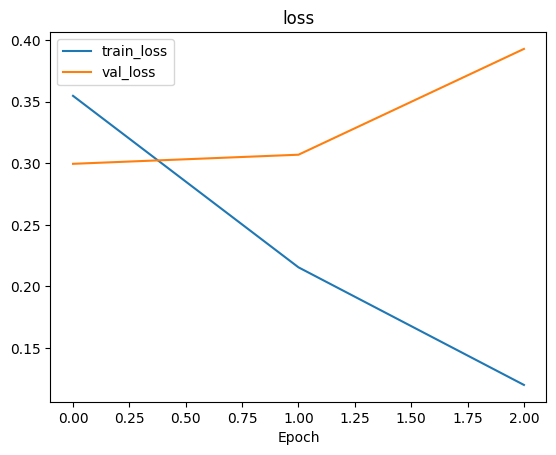

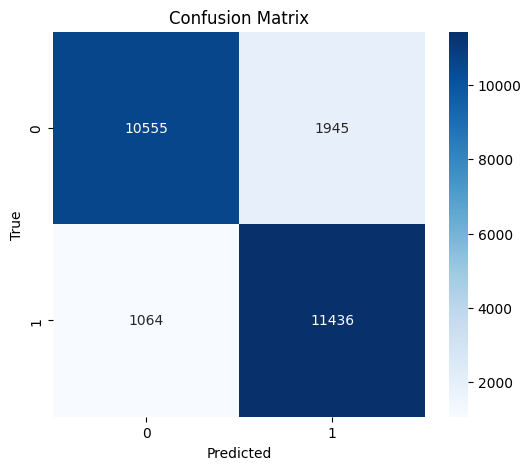

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification

# Constants
MAX_LENGTH = 128    # Max sequence length for BERT
BATCH_SIZE = 8     # Adjust based on GPU memory
EPOCHS = 3          # Number of fine-tuning epochs
MODEL_NAME = "bert-base-uncased"  # Pre-trained BERT model

def load_and_prepare_data():
    """Load IMDB dataset via TFDS and split into train/val/test."""
    ds, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

    # Load full train split
    train_ds = ds['train'].batch(info.splits['train'].num_examples)
    train_examples, train_labels = tfds.as_numpy(next(iter(train_ds)))

    # Load full test split
    test_ds = ds['test'].batch(info.splits['test'].num_examples)
    test_examples, test_labels = tfds.as_numpy(next(iter(test_ds)))

    # Decode bytes to strings
    train_texts = [ex.decode('utf-8') for ex in train_examples]
    test_texts  = [ex.decode('utf-8') for ex in test_examples]

    # Create an 80/20 train/validation split
    tr_texts, val_texts, tr_labels, val_labels = train_test_split(
        train_texts, train_labels, test_size=0.2, random_state=42
    )

    return (tr_texts, tr_labels), (val_texts, val_labels), (test_texts, test_labels)

def tokenize_data(texts, tokenizer):
    """Tokenize list of texts for BERT input."""
    return tokenizer(
        texts,
        max_length=MAX_LENGTH,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

def create_tf_dataset(encodings, labels):
    """Convert encodings and labels to a batched tf.data.Dataset."""
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    return dataset.shuffle(1000).batch(BATCH_SIZE)

def build_model():
    """Instantiate and compile the BERT classification model."""
    model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

    # Use legacy Adam optimizer to ensure compatibility and avoid errors
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

def main():
    # Load & split data
    (train_texts, train_labels), (val_texts, val_labels), (test_texts, test_labels) = load_and_prepare_data()

    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

    # Tokenize datasets
    train_enc = tokenize_data(train_texts, tokenizer)
    val_enc   = tokenize_data(val_texts, tokenizer)
    test_enc  = tokenize_data(test_texts, tokenizer)

    # Build tf.data.Datasets
    train_ds = create_tf_dataset(train_enc, train_labels)
    val_ds   = create_tf_dataset(val_enc,   val_labels)
    test_ds  = create_tf_dataset(test_enc,  test_labels)

    # Instantiate and train model
    model = build_model()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1
    )

    # Plot training curves
    for metric in ['accuracy', 'loss']:
        plt.figure()
        plt.plot(history.history[metric], label=f'train_{metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.title(metric)
        plt.xlabel('Epoch')
        plt.legend()
        plt.savefig(f'{metric}_plot.png')

    # Evaluate on test set
    loss, accuracy = model.evaluate(test_ds)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Confusion matrix & classification report
    y_true, y_pred = [], []
    for batch in test_ds:
        inputs, labels = batch
        logits = model.predict(inputs).logits
        preds = np.argmax(logits, axis=1)
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')

    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=['negative','positive']))

    # Save model and tokenizer
    model.save_pretrained('sentiment_bert_model')
    tokenizer.save_pretrained('sentiment_bert_model')
    print("Model and tokenizer saved to 'sentiment_bert_model'.")

if __name__ == '__main__':
    main()